In [1]:
import pandas
import datetime
import numpy
import scipy.optimize
import seaborn as sns
import matplotlib.pyplot as plt
import os
import time
import bs4
import urllib
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib import ticker
%matplotlib inline
from matplotlib import rcParams

In [2]:
# setup some cutoff values we'll use in the analysis
velCutoffUpper = 2000.
velCutoffLower = 0.
numPointsCutoffMLTMLAT = 250

In [3]:
velGmagDF = pandas.read_csv("../data/processed-vels-geomag.txt", sep=' ')
velGmagDF = velGmagDF.drop('Unnamed: 0', axis=1)
# Filter out some values where number of datapoints are pretty low.
countDF = velGmagDF.groupby([ "normMLT", "MLAT" ]).size().reset_index()
countDF.columns = [ "normMLT", "MLAT", "count" ]
# Choose only columns which have atleast 100 points
countDF = countDF[ countDF["count"] >= numPointsCutoffMLTMLAT ].reset_index(drop=True)
# Merge with velsDataDF to filter out unwanted values
velGmagDF = pandas.merge( velGmagDF, countDF,\
                          on=["normMLT", "MLAT"], how='inner' )
velGmagDF.head()

,normMLT,MLAT,vSaps,azim,vMagnErr,azimErr,dtStr,tmStr,date,hour,dst_date,dst_index,dst_bin,AE,AL,AO,AU,minute,count
0,-4.0,60.5,634.32,-10.10,7.19,21.54,20130316,500,2013-03-16 05:00:00,5,2013-03-16 05:00:00,-19.0,"(-25, -10]",731,-575,-210,156,0,2677
1,-4.0,60.5,609.64,-10.92,3.58,9.73,20130316,502,2013-03-16 05:02:00,5,2013-03-16 05:00:00,-19.0,"(-25, -10]",651,-524,-199,127,2,2677
2,-4.0,60.5,613.71,-12.20,4.15,8.27,20130316,504,2013-03-16 05:04:00,5,2013-03-16 05:00:00,-19.0,"(-25, -10]",586,-470,-177,116,4,2677
3,-4.0,60.5,778.50,-16.19,3.80,4.90,20130316,506,2013-03-16 05:06:00,5,2013-03-16 05:00:00,-19.0,"(-25, -10]",562,-418,-137,144,6,2677
4,-4.0,60.5,578.11,-15.40,7.43,12.92,20130316,508,2013-03-16 05:08:00,5,2013-03-16 05:00:00,-19.0,"(-25, -10]",569,-450,-166,119,8,2677


In [4]:
# Create AE bins
aeBins = [ 0, 250, 500, 1000, 1500, 2100 ]
velGmagDF = pandas.concat( [ velGmagDF, \
                    pandas.cut( velGmagDF["AE"], \
                               bins=aeBins ) ], axis=1 )
velGmagDF.columns = [ "normMLT", "MLAT", "vSaps", "azim",\
                         "vMagnErr", "azimErr", "dtStr", "tmStr",\
                         "date", "hour", "dst_date",\
                         "dst_index", "dst_bin", \
                         "AE", "AL", "AO", "AU", "minute", "count","AE_bin"]
velGmagDF.head()

,normMLT,MLAT,vSaps,azim,vMagnErr,azimErr,dtStr,tmStr,date,hour,dst_date,dst_index,dst_bin,AE,AL,AO,AU,minute,count,AE_bin
0,-4.0,60.5,634.32,-10.10,7.19,21.54,20130316,500,2013-03-16 05:00:00,5,2013-03-16 05:00:00,-19.0,"(-25, -10]",731,-575,-210,156,0,2677,"(500, 1000]"
1,-4.0,60.5,609.64,-10.92,3.58,9.73,20130316,502,2013-03-16 05:02:00,5,2013-03-16 05:00:00,-19.0,"(-25, -10]",651,-524,-199,127,2,2677,"(500, 1000]"
2,-4.0,60.5,613.71,-12.20,4.15,8.27,20130316,504,2013-03-16 05:04:00,5,2013-03-16 05:00:00,-19.0,"(-25, -10]",586,-470,-177,116,4,2677,"(500, 1000]"
3,-4.0,60.5,778.50,-16.19,3.80,4.90,20130316,506,2013-03-16 05:06:00,5,2013-03-16 05:00:00,-19.0,"(-25, -10]",562,-418,-137,144,6,2677,"(500, 1000]"
4,-4.0,60.5,578.11,-15.40,7.43,12.92,20130316,508,2013-03-16 05:08:00,5,2013-03-16 05:00:00,-19.0,"(-25, -10]",569,-450,-166,119,8,2677,"(500, 1000]"


In [5]:
# Groupby AE bin
aeLocDF = velGmagDF.groupby( [ "AE_bin", "normMLT", "MLAT" ] ).mean().reset_index()
aeLocDF = aeLocDF.dropna().reset_index(drop=True)
aeLocDF.head()

,AE_bin,normMLT,MLAT,vSaps,azim,vMagnErr,azimErr,dtStr,tmStr,hour,dst_index,AE,AL,AO,AU,minute,count
0,"(0, 250]",-7.0,58.0,363.390000,-17.050,4.1000,9.353333,2.011399e+07,134.0,1.0,-89.00,218.666667,-70.333333,39.0,148.333333,34.0,417.0
1,"(0, 250]",-7.0,58.5,383.616667,-17.050,4.1000,9.353333,2.011399e+07,134.0,1.0,-89.00,218.666667,-70.333333,39.0,148.333333,34.0,440.0
2,"(0, 250]",-7.0,59.0,517.172500,-15.790,5.1825,11.357500,2.011323e+07,136.0,1.0,-92.25,223.250000,-72.750000,39.0,150.500000,36.0,441.0
3,"(0, 250]",-7.0,59.5,640.502500,-14.705,3.1825,7.760000,2.011323e+07,136.0,1.0,-92.25,223.250000,-72.750000,39.0,150.500000,36.0,480.0
4,"(0, 250]",-7.0,60.0,693.245000,-14.685,2.4125,5.522500,2.011323e+07,136.0,1.0,-92.25,223.250000,-72.750000,39.0,150.500000,36.0,488.0


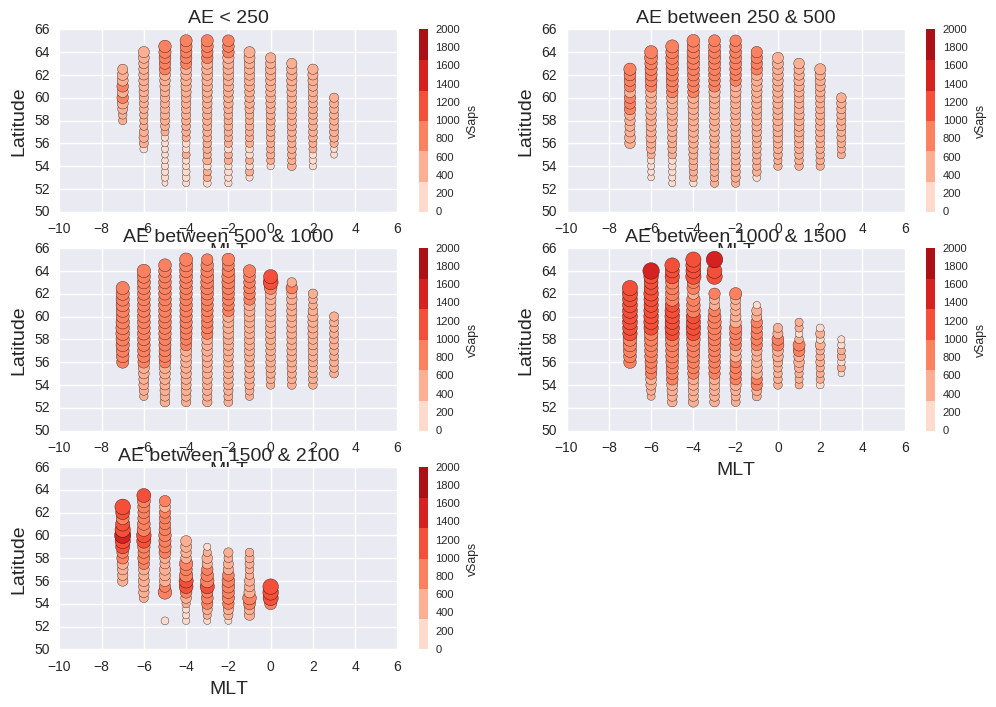

In [6]:
# Make a comparison plot of the data
# for prob of occ at diff locs
# Set up the matplotlib figure
f = plt.figure(figsize=(12, 8))
ax1 = f.add_subplot(3,2,1)
ax2 = f.add_subplot(3,2,2)
ax3 = f.add_subplot(3,2,3)
ax4 = f.add_subplot(3,2,4)
ax5 = f.add_subplot(3,2,5)

sns.set_style("darkgrid")
sns.set_context("paper")
seaMap = ListedColormap(sns.color_palette("Reds"))
# (0,250]
aeSapsMLTLat250 = aeLocDF[ aeLocDF["AE_bin"] == "(0, 250]" ]
aeSapsMLTLat250.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='vSaps',
              s=aeSapsMLTLat250["vSaps"]/10, cmap=seaMap, vmin=0, vmax=2000, ax=ax1)
ax1.set_xlabel("MLT", fontsize=14)
ax1.set_ylabel("Latitude", fontsize=14)
ax1.set_title( "AE < 250", fontsize=14 )
ax1.set_xlim([-10., 6.])
# (250,500]
aeSapsMLTLat500 = aeLocDF[ aeLocDF["AE_bin"] == "(250, 500]" ]
aeSapsMLTLat500.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='vSaps',
              s=aeSapsMLTLat500["vSaps"]/10, cmap=seaMap, vmin=0, vmax=2000, ax=ax2)
ax2.set_xlabel("MLT", fontsize=14)
ax2.set_ylabel("Latitude", fontsize=14)
ax2.set_title( "AE between 250 & 500", fontsize=14 )
ax2.set_xlim([-10., 6.])
# (500,1000]
aeSapsMLTLat1000 = aeLocDF[ aeLocDF["AE_bin"] == "(500, 1000]" ]
aeSapsMLTLat1000.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='vSaps',
              s=aeSapsMLTLat1000["vSaps"]/10, cmap=seaMap, vmin=0, vmax=2000, ax=ax3)
ax3.set_xlabel("MLT", fontsize=14)
ax3.set_ylabel("Latitude", fontsize=14)
ax3.set_title( "AE between 500 & 1000", fontsize=14 )
ax3.set_xlim([-10., 6.])
# (1000,1500]
aeSapsMLTLat1500 = aeLocDF[ aeLocDF["AE_bin"] == "(1000, 1500]" ]
aeSapsMLTLat1500.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='vSaps',
              s=aeSapsMLTLat1500["vSaps"]/10, cmap=seaMap, vmin=0, vmax=2000, ax=ax4)
ax4.set_xlabel("MLT", fontsize=14)
ax4.set_ylabel("Latitude", fontsize=14)
ax4.set_title( "AE between 1000 & 1500", fontsize=14 )
ax4.set_xlim([-10., 6.])
# (1500,2100]
aeSapsMLTLat2100 = aeLocDF[ aeLocDF["AE_bin"] == "(1500, 2100]" ]
aeSapsMLTLat2100.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='vSaps',
              s=aeSapsMLTLat2100["vSaps"]/10, cmap=seaMap, vmin=0, vmax=2000, ax=ax5)
ax5.set_xlabel("MLT", fontsize=14)
ax5.set_ylabel("Latitude", fontsize=14)
ax5.set_title( "AE between 1500 & 2100", fontsize=14 )
ax5.set_xlim([-10., 6.])

plt.savefig("../figs/allAEBinsVels.pdf",bbox_inches='tight')

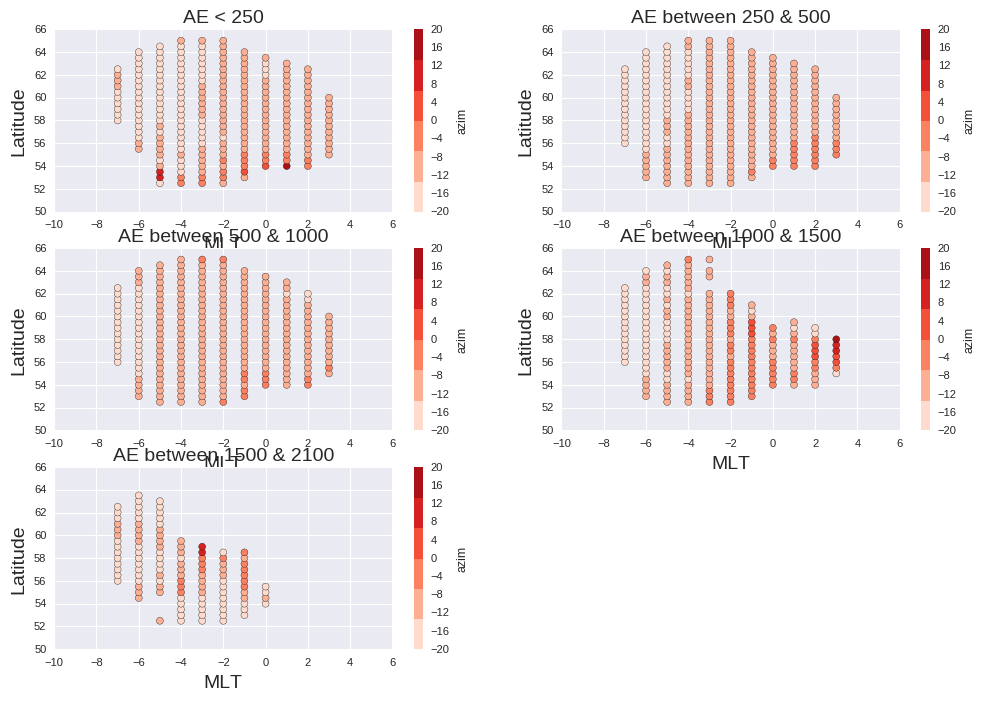

In [7]:
# Make a comparison plot of the data
# for prob of occ at diff locs
# Set up the matplotlib figure
f = plt.figure(figsize=(12, 8))
ax1 = f.add_subplot(3,2,1)
ax2 = f.add_subplot(3,2,2)
ax3 = f.add_subplot(3,2,3)
ax4 = f.add_subplot(3,2,4)
ax5 = f.add_subplot(3,2,5)

sns.set_style("darkgrid")
sns.set_context("paper")
seaMap = ListedColormap(sns.color_palette("Reds"))
# (0,250]
aeSapsMLTLat250 = aeLocDF[ aeLocDF["AE_bin"] == "(0, 250]" ]
aeSapsMLTLat250.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='azim',
              s=25, cmap=seaMap, vmin=-20, vmax=20, ax=ax1)
ax1.set_xlabel("MLT", fontsize=14)
ax1.set_ylabel("Latitude", fontsize=14)
ax1.set_title( "AE < 250", fontsize=14 )
ax1.set_xlim([-10., 6.])
# (250,500]
aeSapsMLTLat500 = aeLocDF[ aeLocDF["AE_bin"] == "(250, 500]" ]
aeSapsMLTLat500.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='azim',
              s=25, cmap=seaMap, vmin=-20, vmax=20, ax=ax2)
ax2.set_xlabel("MLT", fontsize=14)
ax2.set_ylabel("Latitude", fontsize=14)
ax2.set_title( "AE between 250 & 500", fontsize=14 )
ax2.set_xlim([-10., 6.])
# (500,1000]
aeSapsMLTLat1000 = aeLocDF[ aeLocDF["AE_bin"] == "(500, 1000]" ]
aeSapsMLTLat1000.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='azim',
              s=25, cmap=seaMap, vmin=-20, vmax=20, ax=ax3)
ax3.set_xlabel("MLT", fontsize=14)
ax3.set_ylabel("Latitude", fontsize=14)
ax3.set_title( "AE between 500 & 1000", fontsize=14 )
ax3.set_xlim([-10., 6.])
# (1000,1500]
aeSapsMLTLat1500 = aeLocDF[ aeLocDF["AE_bin"] == "(1000, 1500]" ]
aeSapsMLTLat1500.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='azim',
              s=25, cmap=seaMap, vmin=-20, vmax=20, ax=ax4)
ax4.set_xlabel("MLT", fontsize=14)
ax4.set_ylabel("Latitude", fontsize=14)
ax4.set_title( "AE between 1000 & 1500", fontsize=14 )
ax4.set_xlim([-10., 6.])
# (1500,2100]
aeSapsMLTLat2100 = aeLocDF[ aeLocDF["AE_bin"] == "(1500, 2100]" ]
aeSapsMLTLat2100.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='azim',
              s=25, cmap=seaMap, vmin=-20, vmax=20, ax=ax5)
ax5.set_xlabel("MLT", fontsize=14)
ax5.set_ylabel("Latitude", fontsize=14)
ax5.set_title( "AE between 1500 & 2100", fontsize=14 )
ax5.set_xlim([-10., 6.])

plt.savefig("../figs/allAEBinsAzims.pdf",bbox_inches='tight')

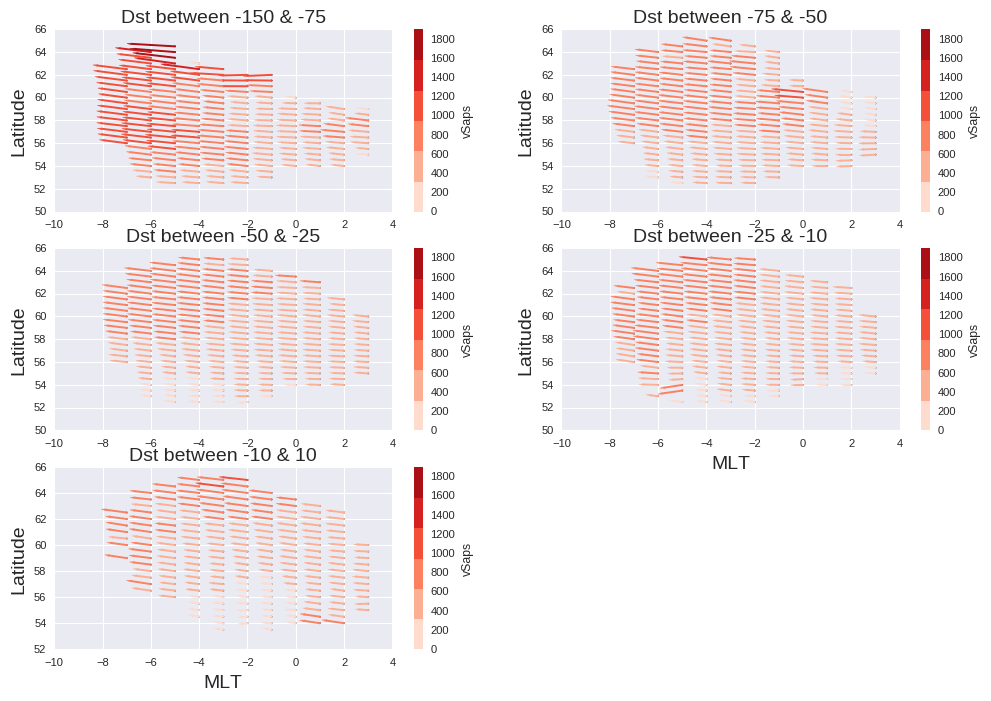

In [8]:
# Groupby Dst bin
dstLocDF = velGmagDF.groupby( [ "dst_bin", "normMLT", "MLAT" ] ).mean().reset_index()
dstLocDF.head()
# Not only velocity magnitudes we'd also 
# like to plot azimuths!
# get the end points of vectors
dstLocDF["plot_MLATEnd"] = numpy.round( (dstLocDF["vSaps"]/1000.) *\
                                numpy.cos( numpy.deg2rad(-90-1*dstLocDF["azim"]) ) +\
                                dstLocDF["MLAT"], 2)
dstLocDF["plot_normMLTEnd"] = numpy.round( (dstLocDF["vSaps"]/1000.) *\
                                numpy.sin( numpy.deg2rad(-90-1*dstLocDF["azim"]) ) +\
                                dstLocDF["normMLT"], 2)
f = plt.figure(figsize=(12, 8))
ax1 = f.add_subplot(3,2,1)
ax2 = f.add_subplot(3,2,2)
ax3 = f.add_subplot(3,2,3)
ax4 = f.add_subplot(3,2,4)
ax5 = f.add_subplot(3,2,5)

# Now setup a velocity scale
velScaleMin = 0.
# round off max velocity to the next hundred
velScaleMax = (dstLocDF["vSaps"].max() + 100.)*100/100\
    - (dstLocDF["vSaps"].max() + 100.)%100

# Seaborn styling
sns.set_style("darkgrid")
sns.set_context("paper")
seaMap = ListedColormap(sns.color_palette("Reds"))

fitResultsDF15075 = dstLocDF[ dstLocDF["dst_bin"] == "(-150, -75]" ]     
fitResultsDF15075.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='vSaps',
              s=1., cmap=seaMap, vmin=velScaleMin, vmax=velScaleMax, ax=ax1)
ax1.set_xlabel("", fontsize=14)
ax1.set_ylabel("Latitude", fontsize=14)
ax1.set_title( "Dst between -150 & -75", fontsize=14 )

plotMLTends = fitResultsDF15075['plot_normMLTEnd'].tolist()
plotMLATends = fitResultsDF15075['plot_MLATEnd'].tolist()
plotMLTbegins = fitResultsDF15075['normMLT'].tolist()
plotMLATbegins = fitResultsDF15075['MLAT'].tolist()
plotVelMagns = fitResultsDF15075['vSaps'].tolist()
# Normalize velocities according to colorbar
colNorm = Normalize( vmin=velScaleMin, vmax=velScaleMax )
for currMLTend, currMLATend, currMLTbgn, currMLATbgn, currVel in\
        zip( plotMLTends, plotMLATends, plotMLTbegins, plotMLATbegins, plotVelMagns ) :
        # get a appropriate color for each bar
        currCol = seaMap( colNorm(currVel) )
        ax1.plot( [currMLTbgn, currMLTend], [ currMLATbgn, currMLATend ], color=currCol )        
        ax1.arrow( currMLTbgn, currMLATbgn, currMLTend-currMLTbgn, currMLATend-currMLATbgn,\
                 head_width=0.15, head_length=0.2, fc=currCol, ec=currCol)
        
        

fitResultsDF7550 = dstLocDF[ dstLocDF["dst_bin"] == "(-75, -50]" ]     
fitResultsDF7550.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='vSaps',
              s=1., cmap=seaMap, vmin=velScaleMin, vmax=velScaleMax, ax=ax2)

plotMLTends = fitResultsDF7550['plot_normMLTEnd'].tolist()
plotMLATends = fitResultsDF7550['plot_MLATEnd'].tolist()
plotMLTbegins = fitResultsDF7550['normMLT'].tolist()
plotMLATbegins = fitResultsDF7550['MLAT'].tolist()
plotVelMagns = fitResultsDF7550['vSaps'].tolist()
# Normalize velocities according to colorbar
colNorm = Normalize( vmin=velScaleMin, vmax=velScaleMax )
for currMLTend, currMLATend, currMLTbgn, currMLATbgn, currVel in\
        zip( plotMLTends, plotMLATends, plotMLTbegins, plotMLATbegins, plotVelMagns ) :
        # get a appropriate color for each bar
        currCol = seaMap( colNorm(currVel) )
        ax2.plot( [currMLTbgn, currMLTend], [ currMLATbgn, currMLATend ], color=currCol )        
        ax2.arrow( currMLTbgn, currMLATbgn, currMLTend-currMLTbgn, currMLATend-currMLATbgn,\
                 head_width=0.15, head_length=0.2, fc=currCol, ec=currCol)
        
ax2.set_xlabel("", fontsize=14)
ax2.set_ylabel("Latitude", fontsize=14)
ax2.set_title( "Dst between -75 & -50", fontsize=14 )


fitResultsDF5025 = dstLocDF[ dstLocDF["dst_bin"] == "(-50, -25]" ]     
fitResultsDF5025.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='vSaps',
              s=1., cmap=seaMap, vmin=velScaleMin, vmax=velScaleMax, ax=ax3)

plotMLTends = fitResultsDF5025['plot_normMLTEnd'].tolist()
plotMLATends = fitResultsDF5025['plot_MLATEnd'].tolist()
plotMLTbegins = fitResultsDF5025['normMLT'].tolist()
plotMLATbegins = fitResultsDF5025['MLAT'].tolist()
plotVelMagns = fitResultsDF5025['vSaps'].tolist()
# Normalize velocities according to colorbar
colNorm = Normalize( vmin=velScaleMin, vmax=velScaleMax )
for currMLTend, currMLATend, currMLTbgn, currMLATbgn, currVel in\
        zip( plotMLTends, plotMLATends, plotMLTbegins, plotMLATbegins, plotVelMagns ) :
        # get a appropriate color for each bar
        currCol = seaMap( colNorm(currVel) )
        ax3.plot( [currMLTbgn, currMLTend], [ currMLATbgn, currMLATend ], color=currCol )        
        ax3.arrow( currMLTbgn, currMLATbgn, currMLTend-currMLTbgn, currMLATend-currMLATbgn,\
                 head_width=0.15, head_length=0.2, fc=currCol, ec=currCol)
        
ax3.set_xlabel("", fontsize=14)
ax3.set_ylabel("Latitude", fontsize=14)
ax3.set_title( "Dst between -50 & -25", fontsize=14 )


        
        
fitResultsDF2510 = dstLocDF[ dstLocDF["dst_bin"] == "(-25, -10]" ]     
fitResultsDF2510.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='vSaps',
              s=1., cmap=seaMap, vmin=velScaleMin, vmax=velScaleMax, ax=ax4)

plotMLTends = fitResultsDF2510['plot_normMLTEnd'].tolist()
plotMLATends = fitResultsDF2510['plot_MLATEnd'].tolist()
plotMLTbegins = fitResultsDF2510['normMLT'].tolist()
plotMLATbegins = fitResultsDF2510['MLAT'].tolist()
plotVelMagns = fitResultsDF2510['vSaps'].tolist()
# Normalize velocities according to colorbar
colNorm = Normalize( vmin=velScaleMin, vmax=velScaleMax )
for currMLTend, currMLATend, currMLTbgn, currMLATbgn, currVel in\
        zip( plotMLTends, plotMLATends, plotMLTbegins, plotMLATbegins, plotVelMagns ) :
        # get a appropriate color for each bar
        currCol = seaMap( colNorm(currVel) )
        ax4.plot( [currMLTbgn, currMLTend], [ currMLATbgn, currMLATend ], color=currCol )        
        ax4.arrow( currMLTbgn, currMLATbgn, currMLTend-currMLTbgn, currMLATend-currMLATbgn,\
                 head_width=0.15, head_length=0.2, fc=currCol, ec=currCol)
        

ax4.set_xlabel("MLT", fontsize=14)
ax4.set_ylabel("Latitude", fontsize=14)
ax4.set_title( "Dst between -25 & -10", fontsize=14 )        
        
        
fitResultsDF1010 = dstLocDF[ dstLocDF["dst_bin"] == "(-10, 10]" ]     
fitResultsDF1010.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='vSaps',
              s=1., cmap=seaMap, vmin=velScaleMin, vmax=velScaleMax, ax=ax5)

plotMLTends = fitResultsDF1010['plot_normMLTEnd'].tolist()
plotMLATends = fitResultsDF1010['plot_MLATEnd'].tolist()
plotMLTbegins = fitResultsDF1010['normMLT'].tolist()
plotMLATbegins = fitResultsDF1010['MLAT'].tolist()
plotVelMagns = fitResultsDF1010['vSaps'].tolist()
# Normalize velocities according to colorbar
colNorm = Normalize( vmin=velScaleMin, vmax=velScaleMax )
for currMLTend, currMLATend, currMLTbgn, currMLATbgn, currVel in\
        zip( plotMLTends, plotMLATends, plotMLTbegins, plotMLATbegins, plotVelMagns ) :
        # get a appropriate color for each bar
        currCol = seaMap( colNorm(currVel) )
        ax5.plot( [currMLTbgn, currMLTend], [ currMLATbgn, currMLATend ], color=currCol )        
        ax5.arrow( currMLTbgn, currMLATbgn, currMLTend-currMLTbgn, currMLATend-currMLATbgn,\
                 head_width=0.15, head_length=0.2, fc=currCol, ec=currCol)
ax5.set_xlabel("MLT", fontsize=14)
ax5.set_ylabel("Latitude", fontsize=14)
ax5.set_title( "Dst between -10 & 10", fontsize=14 )
plt.savefig("../figs/allDstBinsVelVecs.pdf",bbox_inches='tight')

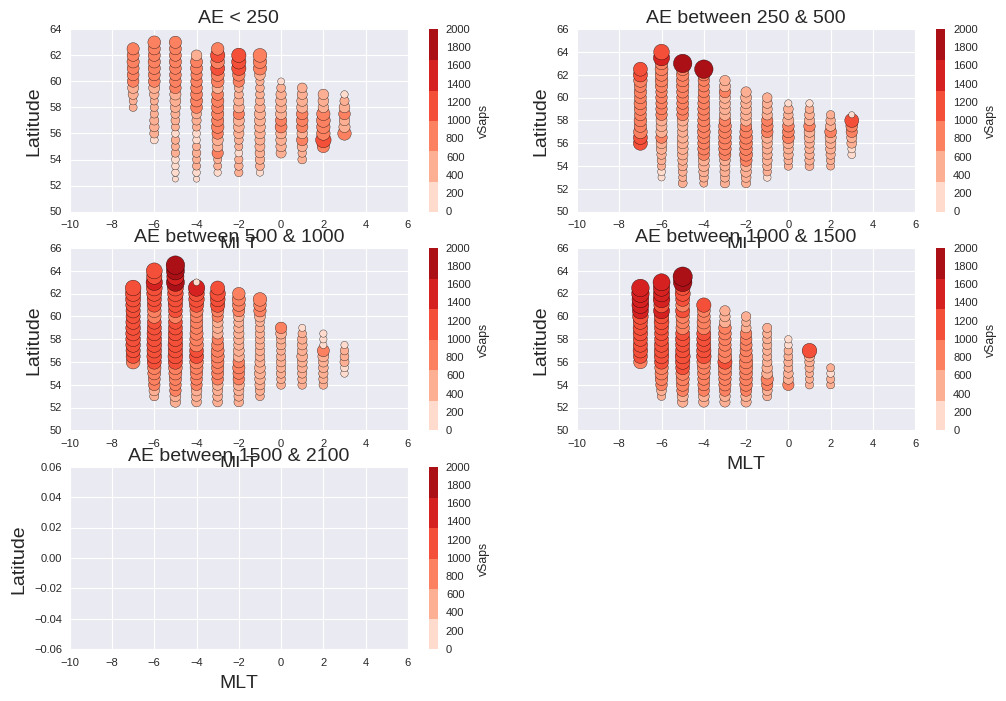

In [36]:
### Group by ae and dst bins together
dstAeDF = velGmagDF.groupby( [ "dst_bin", "AE_bin", "normMLT", "MLAT" ] ).mean().reset_index()
# Make a comparison plot of the data
# for prob of occ at diff locs
# Set up the matplotlib figure
f = plt.figure(figsize=(12, 8))
ax1 = f.add_subplot(3,2,1)
ax2 = f.add_subplot(3,2,2)
ax3 = f.add_subplot(3,2,3)
ax4 = f.add_subplot(3,2,4)
ax5 = f.add_subplot(3,2,5)

dstBinSel = "(-150, -75]"
subDstBinLocDF = dstAeDF[ dstAeDF["dst_bin"] == dstBinSel ]
sns.set_style("darkgrid")
sns.set_context("paper")
seaMap = ListedColormap(sns.color_palette("Reds"))
# (0,250]
aeSapsMLTLat250 = subDstBinLocDF[ subDstBinLocDF["AE_bin"] == "(0, 250]" ]
aeSapsMLTLat250.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='vSaps',
              s=aeSapsMLTLat250["vSaps"]/10, cmap=seaMap, vmin=0, vmax=2000, ax=ax1)
ax1.set_xlabel("MLT", fontsize=14)
ax1.set_ylabel("Latitude", fontsize=14)
ax1.set_title( "AE < 250", fontsize=14 )
ax1.set_xlim([-10., 6.])
# (250,500]
aeSapsMLTLat500 = subDstBinLocDF[ subDstBinLocDF["AE_bin"] == "(250, 500]" ]
aeSapsMLTLat500.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='vSaps',
              s=aeSapsMLTLat500["vSaps"]/10, cmap=seaMap, vmin=0, vmax=2000, ax=ax2)
ax2.set_xlabel("MLT", fontsize=14)
ax2.set_ylabel("Latitude", fontsize=14)
ax2.set_title( "AE between 250 & 500", fontsize=14 )
ax2.set_xlim([-10., 6.])
# (500,1000]
aeSapsMLTLat1000 = subDstBinLocDF[ subDstBinLocDF["AE_bin"] == "(500, 1000]" ]
aeSapsMLTLat1000.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='vSaps',
              s=aeSapsMLTLat1000["vSaps"]/10, cmap=seaMap, vmin=0, vmax=2000, ax=ax3)
ax3.set_xlabel("MLT", fontsize=14)
ax3.set_ylabel("Latitude", fontsize=14)
ax3.set_title( "AE between 500 & 1000", fontsize=14 )
ax3.set_xlim([-10., 6.])
# (1000,1500]
aeSapsMLTLat1500 = subDstBinLocDF[ subDstBinLocDF["AE_bin"] == "(1000, 1500]" ]
aeSapsMLTLat1500.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='vSaps',
              s=aeSapsMLTLat1500["vSaps"]/10, cmap=seaMap, vmin=0, vmax=2000, ax=ax4)
ax4.set_xlabel("MLT", fontsize=14)
ax4.set_ylabel("Latitude", fontsize=14)
ax4.set_title( "AE between 1000 & 1500", fontsize=14 )
ax4.set_xlim([-10., 6.])
# (1500,2100]
aeSapsMLTLat2100 = subDstBinLocDF[ subDstBinLocDF["AE_bin"] == "(1500, 2100]" ]
aeSapsMLTLat2100.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='vSaps',
              s=aeSapsMLTLat2100["vSaps"]/10, cmap=seaMap, vmin=0, vmax=2000, ax=ax5)
ax5.set_xlabel("MLT", fontsize=14)
ax5.set_ylabel("Latitude", fontsize=14)
ax5.set_title( "AE between 1500 & 2100", fontsize=14 )
ax5.set_xlim([-10., 6.])

plt.savefig("../figs/dstAEBinsVels-" + dstBinSel + ".pdf",bbox_inches='tight')

In [22]:
print dstAeDF["dst_bin"].unique()
print dstAeDF["AE_bin"].unique()

['(-10, 10]' '(-150, -75]' '(-25, -10]' '(-50, -25]' '(-75, -50]']
[(0, 250], (250, 500], (500, 1000], (1000, 1500], (1500, 2100]]
Categories (5, object): [(0, 250] < (250, 500] < (500, 1000] < (1000, 1500] < (1500, 2100]]


In [24]:
subDF.head()

,dst_bin,AE_bin,normMLT,MLAT,vSaps,azim,vMagnErr,azimErr,dtStr,tmStr,hour,dst_index,AE,AL,AO,AU,minute,count
0,"(-10, 10]","(0, 250]",-0.253906,61.402832,560.943697,-13.892992,5.968468,15.65814,2.012575e+07,723.350469,6.933878,-2.671505,170.914122,-82.673319,2.790948,88.240802,29.962705,1591.361153
